## Introduction

Lets create a function to perform operations for running models.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
import warnings
warnings.filterwarnings("ignore")

def RunRegressionModel(inputDf, modelName, modelObj, predictColm, testSize, **kwargs):
    randomState = kwargs.get('randomState', None)
    showPlot = kwargs.get('showPlot', False)
    features = kwargs.get('features', [])

    if isinstance(features, (list)):
        if not features:
            print("Error: No feature columns list specified, returning")
            return
    else:
        if features.empty:
            print("Error: No feature columns specified, returning")
            return
    NumFeatures = len(features)
    print("# Performing ", ("Single" if NumFeatures == 1 else "Multi"),modelName," with")
    print("   testSize:", testSize, ",randomState:", randomState,",showPlot:", showPlot)
    print("   features(",NumFeatures,"):", ", ".join(features))

    X = inputDf[features]
    y = inputDf[[predictColm]]

    if(randomState == None):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize, random_state = randomState)

    modelObj.fit(X_train, y_train)
    y_pred = modelObj.predict(X_test)
    
    # Reset index of y_test for alignment
    y_test_reset = y_test.reset_index(drop=True)
    # Convert y_pred to a DataFrame
    df_y_pred = pd.DataFrame(y_pred, columns=['prediction'])
    # Concatenate y_test DataFrame with y_pred DataFrame column-wise, ensuring alignment
    combined_y = pd.concat([y_test_reset.reset_index(drop=True), df_y_pred.reset_index(drop=True)], axis=1)
    # Rename the columns to 'truth' and 'prediction' accordingly
    combined_y.columns = ['truth', 'prediction']
    combined_y['diff'] = combined_y['truth']-combined_y['prediction']

    if (NumFeatures == 1 and showPlot == True):
        plt.scatter(X, y, color='rebeccapurple', label="Datapoints") # always take full dataset
        # regression line
        slope = modelObj.coef_[0]
        intercept = modelObj.intercept_
        x_values = np.array([X.min(), X.max()])
        y_values = slope * x_values + intercept
        plt.plot(x_values, y_values, color='red', label='Regression Line')
        plt.xlabel(features) # "Overall Qual")
        plt.ylabel(predictColm)
        plt.title("Plot for {}".format(modelName))
        plt.grid()
        plt.legend()
        plt.show()

    return (metrics.r2_score(y_test, y_pred), metrics.mean_absolute_error(y_test, y_pred), combined_y)

# Verify the results with various models


# Performing  Single LinearRegression  with
   testSize: 0.3 ,randomState: 23 ,showPlot: True
   features( 1 ): Overall Qual


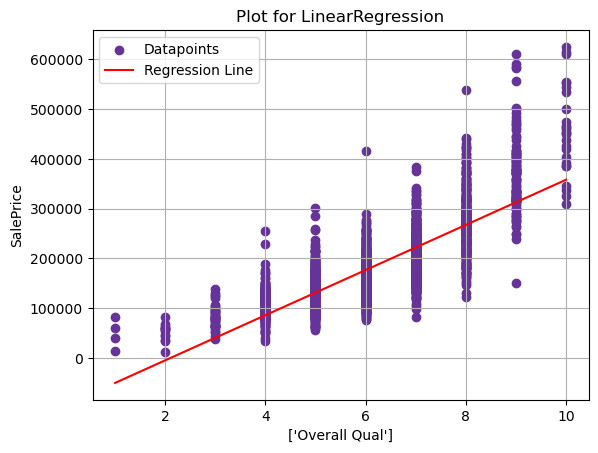

LR_1: Accuracy: 66 % , Error: 33434.17545330617
------------------------------------------------------------
# Performing  Single SGDRegressor  with
   testSize: 0.3 ,randomState: 23 ,showPlot: True
   features( 1 ): Overall Qual


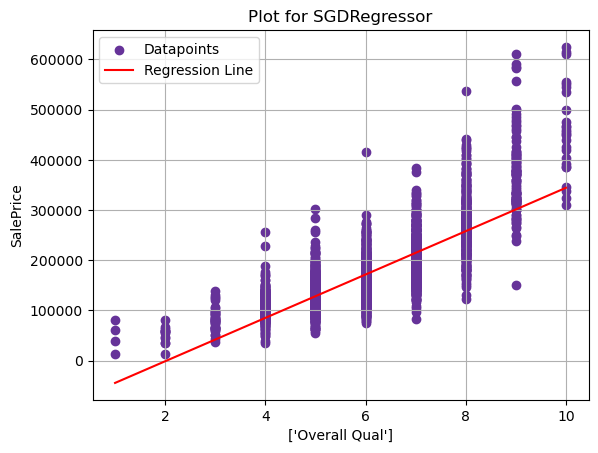

sgdr1: Accuracy: 66 % , Error: 32967.54678213807
------------------------------------------------------------
# Performing  Multi LinearRegression  with
   testSize: 0.3 ,randomState: 23 ,showPlot: False
   features( 3 ): Overall Qual, Gr Liv Area, Garage Cars
lr3coms: Accuracy: 78 % , Error: 33434.17545330617
------------------------------------------------------------
# Performing  Multi LinearRegression  with
   testSize: 0.3 ,randomState: 23 ,showPlot: False
   features( 6 ): Overall Qual, Gr Liv Area, Garage Cars, Year Built, Full Bath, Year Remod/Add
lrselcoms: Accuracy: 80 % , lr2selcoms: 33434.17545330617
------------------------------------------------------------
# Performing  Multi LinearRegression  with
   testSize: 0.3 ,randomState: 23 ,showPlot: False
   features( 10 ): Lot Area, Overall Qual, Overall Cond, Year Built, Year Remod/Add, Gr Liv Area, Full Bath, Bedroom AbvGr, Fireplaces, Garage Cars
lrallcoms: Accuracy: 83 % , lr3allcoms: 33434.17545330617
------------------

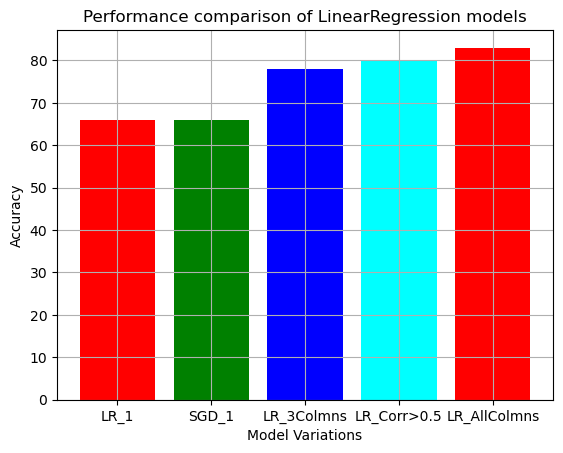

In [3]:
# test with various options& show comparison
from sklearn.linear_model import LinearRegression
datafile = "HousingData.csv"
df = pd.read_csv(datafile)
#showPlot=True, 
models = [] #"Julia", "Java", "Python", "R"]
accs = []
lr1 = RunRegressionModel(df, "LinearRegression", LinearRegression(), 'SalePrice', 0.3, randomState=23, features=['Overall Qual'], showPlot=True)
models.append("LR_1")
accs.append(round(lr1[0]*100))
print("LR_1: Accuracy:",round(lr1[0]*100),"%",", Error:",lr1[1])
print("--" * 30)
sgdr1 = RunRegressionModel(df, "SGDRegressor", SGDRegressor(), 'SalePrice', 0.3, randomState=23, features=['Overall Qual'], showPlot=True)
models.append("SGD_1")
accs.append(round(sgdr1[0]*100))
print("sgdr1: Accuracy:",round(sgdr1[0]*100),"%",", Error:",sgdr1[1])
print("--" * 30)
lr3coms = RunRegressionModel(df, "LinearRegression", LinearRegression(), 'SalePrice', 0.3, randomState=23,
            features=['Overall Qual', 'Gr Liv Area', 'Garage Cars'])
models.append("LR_3Colmns")
accs.append(round(lr3coms[0]*100))
print("lr3coms: Accuracy:",round(lr3coms[0]*100),"%",", Error:",lr1[1])
print("--" * 30)
dfCorr = df.corr()
filteredDf = dfCorr[((dfCorr > 0.5) | (dfCorr < -0.5)) & (dfCorr !=1.000)]
tempsr = filteredDf.unstack().sort_values(ascending = False)['SalePrice']
selcolms = tempsr.loc[tempsr.notnull()]
lrselcoms = RunRegressionModel(df, "LinearRegression", LinearRegression(), 'SalePrice', 0.3, randomState=23, features=selcolms.index)
models.append("LR_Corr>0.5")
accs.append(round(lrselcoms[0]*100))
print("lrselcoms: Accuracy:",round(lrselcoms[0]*100),"%",", lr2selcoms:",lr1[1])
print("--" * 30)
allcolms = df.columns.drop(['SalePrice','Unnamed: 0'])
lrallcoms = RunRegressionModel(df, "LinearRegression", LinearRegression(), 'SalePrice', 0.3, randomState=23, features=allcolms)
models.append("LR_AllColmns")
accs.append(round(lrallcoms[0]*100))
print("lrallcoms: Accuracy:",round(lrallcoms[0]*100),"%",", lr3allcoms:",lr1[1])
print("--" * 30)

print("models:", models, ", accs:",accs, "types:",type(models),",",type(accs))
# Plotting the bar itself
# The bar plot method plt.bar. Dox: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html
plt.bar(models, accs, color=["red", "green", "blue", "cyan"]) #, alpha = 0.20)
plt.title("Performance comparison of LinearRegression models")
plt.xlabel("Model Variations")
plt.ylabel('Accuracy')
plt.grid()
plt.show()